<a href="https://www.kaggle.com/code/amandahu0531/xgboost?scriptVersionId=237551445" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

[11:01:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[11:01:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"



XGBoost (GPU) Results:
 RMSE: 3423591.16, R2: 0.4139, MAE: 925756.27
Baseline (mean) RMSE: 4471967.84


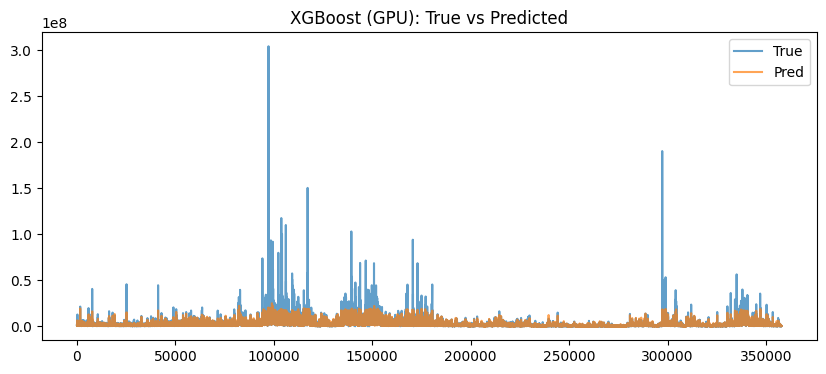

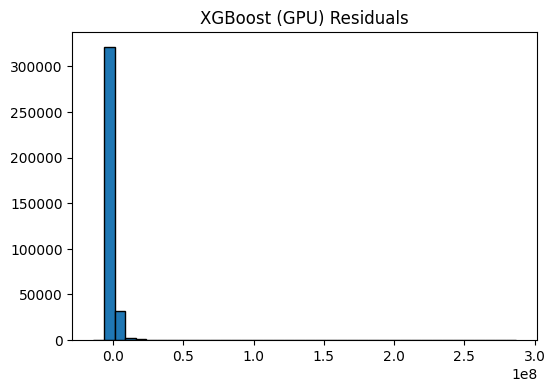

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
from scipy.stats.mstats import winsorize
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import shap
from tqdm import tqdm
import os
import time
#===================== GLOBAL SETTINGS =====================#
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

#---------------- winsorize helper ----------------#
def winsorize_array_2d(X, limits=(0.01, 0.025)):
    """
    Apply column-wise winsorization to a 2D array.
    """
    return np.apply_along_axis(lambda col: winsorize(col, limits=limits), 0, X)

#===================== TASK 1: PREP & RF MODEL =====================#
logger.info("1. Load and clean data")
data = pd.read_csv(r"/kaggle/input/crypto-feature/crypto_features_10min.csv", parse_dates=["date"])
logger.info(f" Data shape: {data.shape}")

# Feature engineering
logger.info("2. Feature engineering")
data['vol_diff_30m_60m'] = data['rolling_volume_30min'] - data['rolling_volume_60min']
data['hour'] = data['date'].dt.hour
data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)

numeric_features = [
    'log_return_10min', 'rolling_vol_30min', 'rolling_volume_30min', 'z_volume_30min',
    'rolling_trades_mean_30min', 'z_trades_30min', 'z_close_30min', 'rolling_vol_60min',
    'rolling_volume_60min', 'z_volume_60min', 'rolling_trades_mean_60min', 'z_trades_60min',
    'z_close_60min', 'rolling_vol_120min', 'rolling_volume_120min', 'z_volume_120min',
    'rolling_trades_mean_120min', 'z_trades_120min', 'z_close_120min', 'hl_range',
    'minute_of_day', 'is_morning', 'vol_diff_30m_60m', 'hour_sin', 'hour_cos'
]
categorical_features = ['asset']
target = 'future_volume_1h'

logger.info("3. Subset & fill missing")
X = data[numeric_features + categorical_features].copy()
y = data[target].copy()
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X[numeric_features] = X[numeric_features].fillna(X[numeric_features].median())
y.replace([np.inf, -np.inf], np.nan, inplace=True)
y.fillna(y.median(), inplace=True)
logger.info(f" X shape: {X.shape}, y shape: {y.shape}")

# Preprocessing pipeline
logger.info("4. Setting up preprocessing")
winsor_tf = FunctionTransformer(winsorize_array_2d, validate=False)
num_pipeline = Pipeline([
    ('winsor', winsor_tf),
    ('scale', RobustScaler())
])
cat_pipeline = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numeric_features),
    ('cat', cat_pipeline, categorical_features)
], n_jobs=-1)

# Train-test split
logger.info("5. Train-test split")
n_train = int(len(X) * 0.8)
X_train, X_test = X.iloc[:n_train], X.iloc[n_train:]
y_train, y_test = y.iloc[:n_train], y.iloc[n_train:]
logger.info(f" Train: {X_train.shape}, Test: {X_test.shape}")

# Preprocess data
logger.info("6. Preprocessing data")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Convert to NumPy arrays for XGBoost
X_train_processed = X_train_processed.toarray() if hasattr(X_train_processed, 'toarray') else X_train_processed
X_test_processed = X_test_processed.toarray() if hasattr(X_test_processed, 'toarray') else X_test_processed
y_train_processed = np.log1p(y_train.values)
y_test_processed = y_test.values

# XGBoost pipeline with GPU
logger.info("7. Building GPU XGBoost pipeline")
xgb_model = XGBRegressor(
    n_estimators=200,
    max_depth=10,
    min_child_weight=4,  # Equivalent to min_samples_leaf
    colsample_bytree=np.sqrt(X_train_processed.shape[1]) / X_train_processed.shape[1],  # Equivalent to max_features='sqrt'
    tree_method='gpu_hist',  # Enable GPU
    random_state=42
)

# Train on GPU
logger.info("8. Training XGBoost model on GPU")
start_time = time.time()
xgb_model.fit(X_train_processed, y_train_processed)
logger.info(f"Training complete in {time.time() - start_time:.2f} seconds")

# Predict on GPU
logger.info("9. Predicting on GPU")
y_pred_xgb = np.expm1(xgb_model.predict(X_test_processed))

# Metrics
rmse_xgb = np.sqrt(mean_squared_error(y_test_processed, y_pred_xgb))
r2_xgb = r2_score(y_test_processed, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test_processed, y_pred_xgb)
print("XGBoost (GPU) Results:")
print(f" RMSE: {rmse_xgb:.2f}, R2: {r2_xgb:.4f}, MAE: {mae_xgb:.2f}")

# Baseline
baseline_rmse = np.sqrt(((y_test - y_test.mean())**2).mean())
print(f"Baseline (mean) RMSE: {baseline_rmse:.2f}")

#===================== Task 1 Visualizations =====================#
def plot_results(y_true, y_pred, title):
    plt.figure(figsize=(10, 4))
    plt.plot(y_true.values, label='True', alpha=0.7)
    plt.plot(y_pred, label='Pred', alpha=0.7)
    plt.title(title)
    plt.legend()
    plt.show()

logger.info("10. Plotting XGBoost results")
plot_results(y_test, y_pred_xgb, 'XGBoost (GPU): True vs Predicted')

plt.figure(figsize=(6, 4))
plt.hist(y_test - y_pred_xgb, bins=40, edgecolor='black')
plt.title('XGBoost (GPU) Residuals')
plt.show()



# Task 2: SHAP Analysi #

Computing SHAP values: 100%|██████████| 36/36 [01:04<00:00,  1.78s/it]


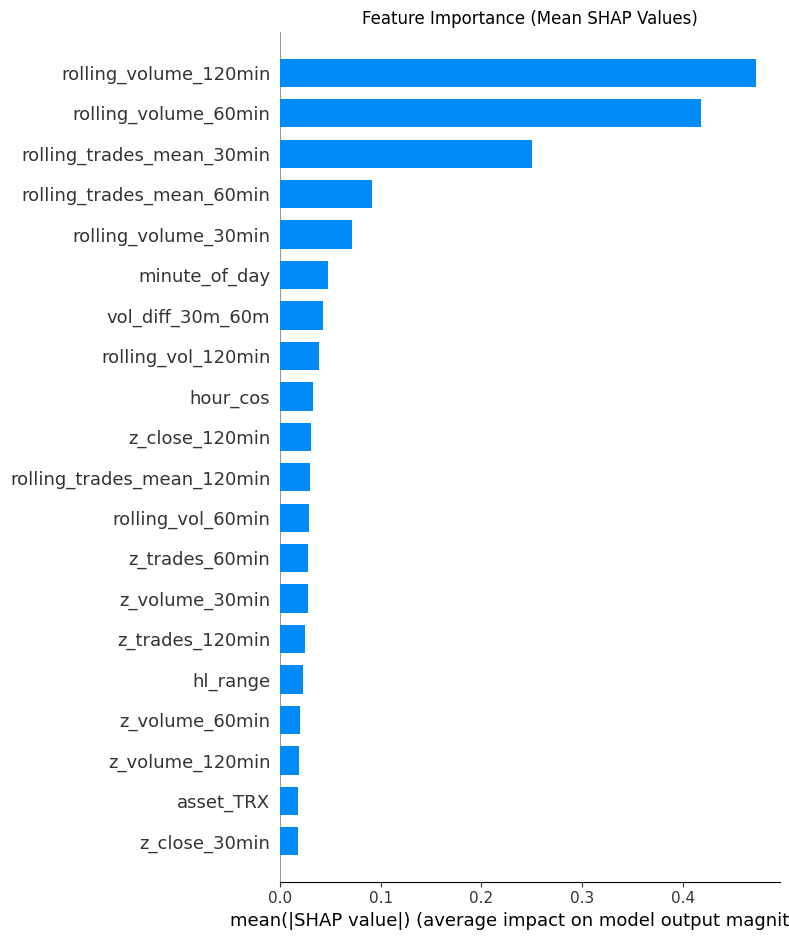

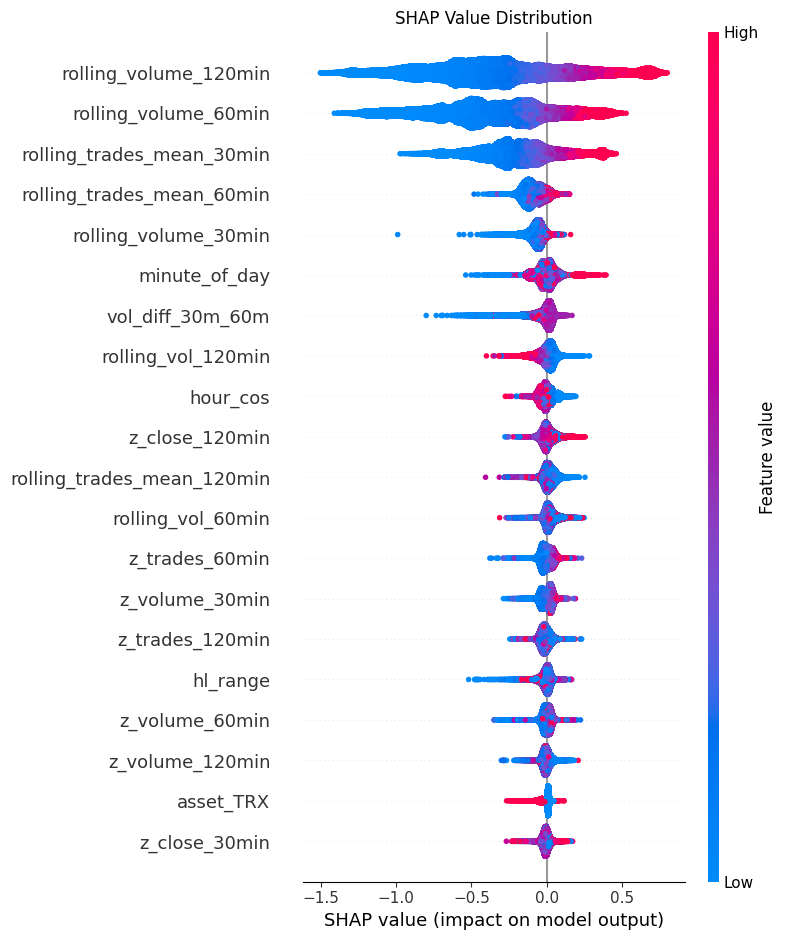

<Figure size 1000x400 with 0 Axes>

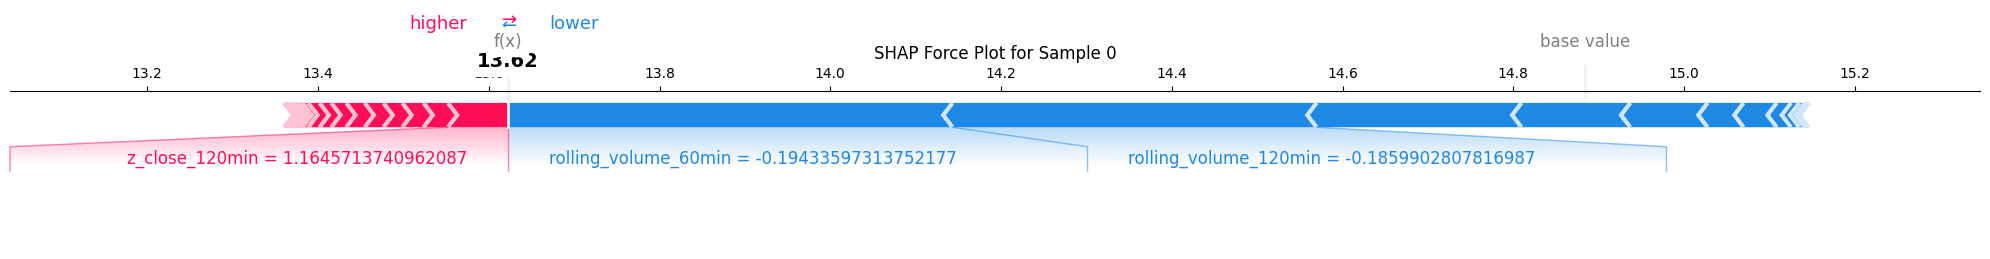

In [10]:
#===================== Task 2: SHAP Analysis =====================#
# Define results directory
results_dir = "./results"
os.makedirs(results_dir, exist_ok=True)

# Get feature names after preprocessing
feature_names = numeric_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
logger.info(f"Total features for SHAP: {len(feature_names)}")

# Use all samples for SHAP
X_test_shap = X_test_processed
X_test_shap_df = pd.DataFrame(X_test_shap, columns=feature_names)
logger.info(f"Using {X_test_shap.shape[0]} samples for SHAP analysis")

# Initialize SHAP TreeExplainer
logger.info("Initializing SHAP TreeExplainer")
start_time = time.time()
explainer = shap.TreeExplainer(xgb_model, feature_names=feature_names)
logger.info(f"SHAP TreeExplainer initialized in {time.time() - start_time:.2f} seconds")

# Compute SHAP values with GPU and progress bar
logger.info("Computing SHAP values with GPU")
start_time = time.time()

# Split data into chunks for memory management
chunk_size = 10000  # Process 10,000 samples per chunk
chunks = [X_test_shap[i:i + chunk_size] for i in range(0, X_test_shap.shape[0], chunk_size)]
logger.info(f"Total chunks to process: {len(chunks)}")

shap_values_chunks = []
for chunk in tqdm(chunks, desc="Computing SHAP values", total=len(chunks)):
    shap_values_chunk = explainer.shap_values(chunk)
    shap_values_chunks.append(shap_values_chunk)

shap_values = np.vstack(shap_values_chunks)
logger.info(f"SHAP values computed in {time.time() - start_time:.2f} seconds")

# Save SHAP values with compression
logger.info("Saving SHAP values")
np.savez_compressed(os.path.join(results_dir, "shap_values.npz"), shap_values=shap_values)
logger.info("SHAP values saved to results/shap_values.npz")

# Plot 1: Feature Importance (Mean Absolute SHAP Values)
logger.info("Generating SHAP feature importance plot")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_shap_df, plot_type="bar", show=False)
plt.title("Feature Importance (Mean SHAP Values)")
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "shap_feature_importance.png"))
plt.show()
logger.info("SHAP feature importance plot saved to results/shap_feature_importance.png")

# Plot 2: SHAP Summary Plot (Distribution of SHAP Values)
logger.info("Generating SHAP summary plot")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_shap_df, show=False)
plt.title("SHAP Value Distribution")
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "shap_summary.png"))
plt.show()
logger.info("SHAP summary plot saved to results/shap_summary.png")

# Plot 3: SHAP Force Plot for a Single Sample
logger.info("Generating SHAP force plot for a single sample")
sample_idx = 0
plt.figure(figsize=(10, 4))
shap.force_plot(explainer.expected_value, shap_values[sample_idx], X_test_shap_df.iloc[sample_idx], matplotlib=True, show=False)
plt.title(f"SHAP Force Plot for Sample {sample_idx}")
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "shap_force_plot.png"))
plt.show()
logger.info("SHAP force plot saved to results/shap_force_plot.png")


# TASK 3: FEATURE SELECTION & MODEL RETRAINING #

In [ ]:
#===================== TASK 3: FEATURE SELECTION & MODEL RETRAINING =====================#
logger.info("11. Feature selection based on SHAP values")
# Feature importance based on mean absolute SHAP values
shap_importance = np.abs(shap_values).mean(axis=0)
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': shap_importance})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Select top 80% of features
top_percent = 0.8
n_features = int(len(feature_importance) * top_percent)
selected_features = feature_importance['feature'].head(n_features).tolist()
logger.info(f"Selected {len(selected_features)} features out of {len(feature_names)}")

# Update preprocessor with selected features
numeric_selected = [f for f in numeric_features if f in selected_features]
cat_selected = [f for f in categorical_features if f in selected_features]
preprocessor_selected = ColumnTransformer([
    ('num', num_pipeline, numeric_selected),
    ('cat', cat_pipeline, cat_selected)
], n_jobs=-1)

# Preprocess data with selected features
logger.info("12. Preprocessing with selected features")
X_train_selected = preprocessor_selected.fit_transform(X_train)
X_test_selected = preprocessor_selected.transform(X_test)

# Convert to NumPy arrays
X_train_selected = X_train_selected.toarray() if hasattr(X_train_selected, 'toarray') else X_train_selected
X_test_selected = X_test_selected.toarray() if hasattr(X_test_selected, 'toarray') else X_test_selected

# Retrain XGBoost model with selected features
logger.info("13. Retraining XGBoost model with selected features on GPU")
xgb_model_selected = XGBRegressor(
    n_estimators=100,
    max_depth=10,
    min_child_weight=4,
    colsample_bytree=np.sqrt(X_train_selected.shape[1]) / X_train_selected.shape[1],
    tree_method='gpu_hist',
    random_state=42
)
start_time = time.time()
xgb_model_selected.fit(X_train_selected, y_train_processed)
logger.info(f"Retraining complete in {time.time() - start_time:.2f} seconds")

# Predict with selected features
logger.info("14. Predicting with selected features on GPU")
y_pred_xgb_selected = np.expm1(xgb_model_selected.predict(X_test_selected))

# Metrics for selected model
rmse_xgb_selected = np.sqrt(mean_squared_error(y_test_processed, y_pred_xgb_selected))
r2_xgb_selected = r2_score(y_test_processed, y_pred_xgb_selected)
mae_xgb_selected = mean_absolute_error(y_test_processed, y_pred_xgb_selected)
print("XGBoost (GPU) with Selected Features Results:")
print(f" RMSE: {rmse_xgb_selected:.2f}, R2: {r2_xgb_selected:.4f}, MAE: {mae_xgb_selected:.2f}")

# Compare performance
logger.info("15. Comparing performance")
print("\nPerformance Comparison:")
print(f"Original Model - RMSE: {rmse_xgb:.2f}, R2: {r2_xgb:.4f}, MAE: {mae_xgb:.2f}")
print(f"Selected Model - RMSE: {rmse_xgb_selected:.2f}, R2: {r2_xgb_selected:.4f}, MAE: {mae_xgb_selected:.2f}")

# Optional: Plot feature importance
logger.info("16. Plotting feature importance")
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.xticks(rotation=45)
plt.title("Top 10 Feature Importance (SHAP Values)")
plt.tight_layout()
plt.show()

# Lightboost

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 5545
[LightGBM] [Info] Number of data points in the train set: 1431589, number of used features: 30
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (38.23 MB) transferred to GPU in 0.037503 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 14.883644
LightGBM (GPU) Results:
 RMSE: 3459867.75, R2: 0.4014, MAE: 939169.41
Baseline (mean) RMSE: 4471967.84


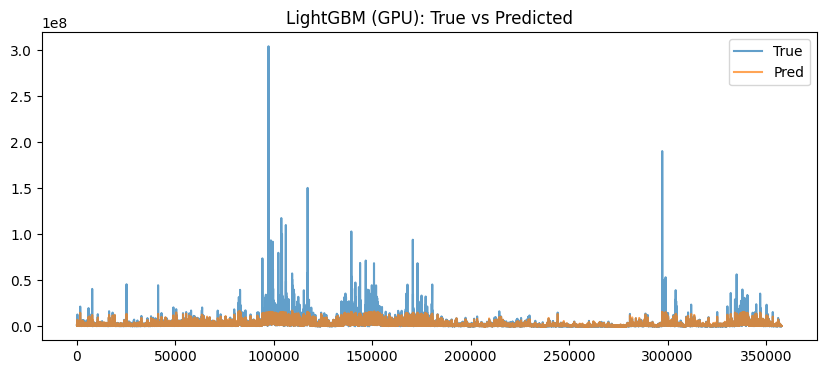

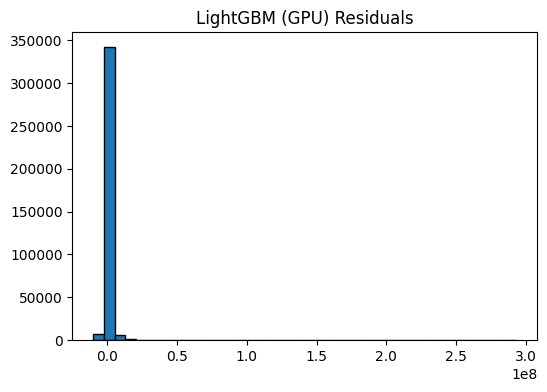

Computing SHAP values: 100%|██████████| 36/36 [01:05<00:00,  1.82s/it]


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4513
[LightGBM] [Info] Number of data points in the train set: 1431589, number of used features: 20
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 20 dense feature groups (27.31 MB) transferred to GPU in 0.034429 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 14.883644
LightGBM (GPU) with Selected Features Results:
 RMSE: 3480023.13, R2: 0.3944, MAE: 945926.48

Performance Comparison:
Original Model - RMSE: 3459867.75, R2: 0.4014, MAE: 939169.41
Selected Model - RMSE: 3480023.13, R2: 0.3944, MAE: 945926.48


<Figure size 1000x400 with 0 Axes>

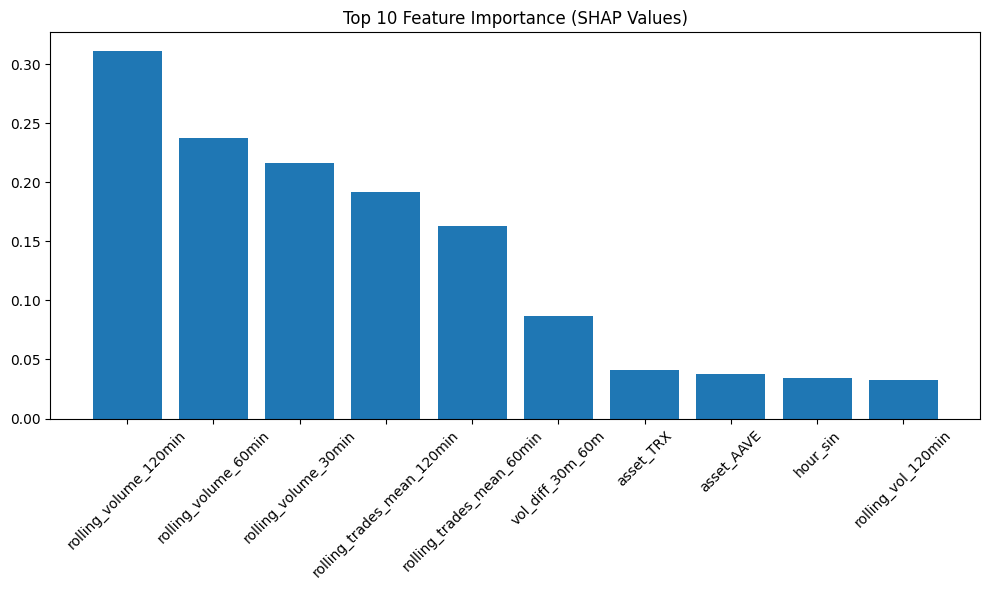

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
from scipy.stats.mstats import winsorize
from lightgbm import LGBMRegressor  # 替换 XGBoost
from sklearn.preprocessing import RobustScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import shap
from tqdm import tqdm
import os
import time

#===================== GLOBAL SETTINGS =====================#
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

#---------------- winsorize helper ----------------#
def winsorize_array_2d(X, limits=(0.01, 0.025)):
    """
    Apply column-wise winsorization to a 2D array.
    """
    return np.apply_along_axis(lambda col: winsorize(col, limits=limits), 0, X)

#===================== TASK 1: PREP & RF MODEL =====================#
logger.info("1. Load and clean data")
data = pd.read_csv(r"/kaggle/input/crypto-feature/crypto_features_10min.csv", parse_dates=["date"])
logger.info(f" Data shape: {data.shape}")

# Feature engineering
logger.info("2. Feature engineering")
data['vol_diff_30m_60m'] = data['rolling_volume_30min'] - data['rolling_volume_60min']
data['hour'] = data['date'].dt.hour
data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)

numeric_features = [
    'log_return_10min', 'rolling_vol_30min', 'rolling_volume_30min', 'z_volume_30min',
    'rolling_trades_mean_30min', 'z_trades_30min', 'z_close_30min', 'rolling_vol_60min',
    'rolling_volume_60min', 'z_volume_60min', 'rolling_trades_mean_60min', 'z_trades_60min',
    'z_close_60min', 'rolling_vol_120min', 'rolling_volume_120min', 'z_volume_120min',
    'rolling_trades_mean_120min', 'z_trades_120min', 'z_close_120min', 'hl_range',
    'minute_of_day', 'is_morning', 'vol_diff_30m_60m', 'hour_sin', 'hour_cos'
]
categorical_features = ['asset']
target = 'future_volume_1h'

logger.info("3. Subset & fill missing")
X = data[numeric_features + categorical_features].copy()
y = data[target].copy()
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X[numeric_features] = X[numeric_features].fillna(X[numeric_features].median())
y.replace([np.inf, -np.inf], np.nan, inplace=True)
y.fillna(y.median(), inplace=True)
logger.info(f" X shape: {X.shape}, y shape: {y.shape}")

# Preprocessing pipeline
logger.info("4. Setting up preprocessing")
winsor_tf = FunctionTransformer(winsorize_array_2d, validate=False)
num_pipeline = Pipeline([
    ('winsor', winsor_tf),
    ('scale', RobustScaler())
])
cat_pipeline = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numeric_features),
    ('cat', cat_pipeline, categorical_features)
], n_jobs=-1)

# Train-test split
logger.info("5. Train-test split")
n_train = int(len(X) * 0.8)
X_train, X_test = X.iloc[:n_train], X.iloc[n_train:]
y_train, y_test = y.iloc[:n_train], y.iloc[n_train:]
logger.info(f" Train: {X_train.shape}, Test: {X_test.shape}")

# Preprocess data
logger.info("6. Preprocessing data")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Convert to NumPy arrays for LightGBM
X_train_processed = X_train_processed.toarray() if hasattr(X_train_processed, 'toarray') else X_train_processed
X_test_processed = X_test_processed.toarray() if hasattr(X_test_processed, 'toarray') else X_test_processed
y_train_processed = np.log1p(y_train.values)
y_test_processed = y_test.values

# LightGBM pipeline with GPU
logger.info("7. Building GPU LightGBM pipeline")
lgb_model = LGBMRegressor(
    n_estimators=100,
    max_depth=10,
    min_child_samples=4,  # Equivalent to min_child_weight in XGBoost
    colsample_bytree=np.sqrt(X_train_processed.shape[1]) / X_train_processed.shape[1],  # Equivalent to max_features='sqrt'
    device='gpu',  # Enable GPU (requires LightGBM with GPU support)
    random_state=42
)

# Train on GPU
logger.info("8. Training LightGBM model on GPU")
start_time = time.time()
lgb_model.fit(X_train_processed, y_train_processed)
logger.info(f"Training complete in {time.time() - start_time:.2f} seconds")

# Predict on GPU
logger.info("9. Predicting on GPU")
y_pred_lgb = np.expm1(lgb_model.predict(X_test_processed))

# Metrics
rmse_lgb = np.sqrt(mean_squared_error(y_test_processed, y_pred_lgb))
r2_lgb = r2_score(y_test_processed, y_pred_lgb)
mae_lgb = mean_absolute_error(y_test_processed, y_pred_lgb)
print("LightGBM (GPU) Results:")
print(f" RMSE: {rmse_lgb:.2f}, R2: {r2_lgb:.4f}, MAE: {mae_lgb:.2f}")

# Baseline
baseline_rmse = np.sqrt(((y_test - y_test.mean())**2).mean())
print(f"Baseline (mean) RMSE: {baseline_rmse:.2f}")

#===================== Task 1 Visualizations =====================#
def plot_results(y_true, y_pred, title):
    plt.figure(figsize=(10, 4))
    plt.plot(y_true.values, label='True', alpha=0.7)
    plt.plot(y_pred, label='Pred', alpha=0.7)
    plt.title(title)
    plt.legend()
    plt.show()

logger.info("10. Plotting LightGBM results")
plot_results(y_test, y_pred_lgb, 'LightGBM (GPU): True vs Predicted')

plt.figure(figsize=(6, 4))
plt.hist(y_test - y_pred_lgb, bins=40, edgecolor='black')
plt.title('LightGBM (GPU) Residuals')
plt.show()

#===================== Task 2: SHAP Analysis =====================#
# Define results directory
results_dir = "./results"
os.makedirs(results_dir, exist_ok=True)

# Get feature names after preprocessing
feature_names = numeric_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
logger.info(f"Total features for SHAP: {len(feature_names)}")

# Use all samples for SHAP
X_test_shap = X_test_processed
X_test_shap_df = pd.DataFrame(X_test_shap, columns=feature_names)
logger.info(f"Using {X_test_shap.shape[0]} samples for SHAP analysis")

# Initialize SHAP TreeExplainer
logger.info("Initializing SHAP TreeExplainer")
start_time = time.time()
explainer = shap.TreeExplainer(lgb_model, feature_names=feature_names)
logger.info(f"SHAP TreeExplainer initialized in {time.time() - start_time:.2f} seconds")

# Compute SHAP values with GPU and progress bar
logger.info("Computing SHAP values with GPU")
start_time = time.time()

# Split data into chunks for memory management
chunk_size = 10000  # Process 10,000 samples per chunk
chunks = [X_test_shap[i:i + chunk_size] for i in range(0, X_test_shap.shape[0], chunk_size)]
logger.info(f"Total chunks to process: {len(chunks)}")

shap_values_chunks = []
for chunk in tqdm(chunks, desc="Computing SHAP values", total=len(chunks)):
    shap_values_chunk = explainer.shap_values(chunk)
    shap_values_chunks.append(shap_values_chunk)

shap_values = np.vstack(shap_values_chunks)
logger.info(f"SHAP values computed in {time.time() - start_time:.2f} seconds")

# Save SHAP values with compression
logger.info("Saving SHAP values")
np.savez_compressed(os.path.join(results_dir, "shap_values.npz"), shap_values=shap_values)
logger.info("SHAP values saved to results/shap_values.npz")

# Plot 1: Feature Importance (Mean Absolute SHAP Values)
logger.info("Generating SHAP feature importance plot")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_shap_df, plot_type="bar", show=False)
plt.title("Feature Importance (Mean SHAP Values)")
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "shap_feature_importance.png"))
plt.close()
logger.info("SHAP feature importance plot saved to results/shap_feature_importance.png")

# Plot 2: SHAP Summary Plot (Distribution of SHAP Values)
logger.info("Generating SHAP summary plot")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_shap_df, show=False)
plt.title("SHAP Value Distribution")
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "shap_summary.png"))
plt.close()
logger.info("SHAP summary plot saved to results/shap_summary.png")

# Plot 3: SHAP Force Plot for a Single Sample
logger.info("Generating SHAP force plot for a single sample")
sample_idx = 0
plt.figure(figsize=(10, 4))
shap.force_plot(explainer.expected_value, shap_values[sample_idx], X_test_shap_df.iloc[sample_idx], matplotlib=True, show=False)
plt.title(f"SHAP Force Plot for Sample {sample_idx}")
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "shap_force_plot.png"))
plt.close()
logger.info("SHAP force plot saved to results/shap_force_plot.png")

#===================== TASK 3: FEATURE SELECTION & MODEL RETRAINING =====================#
logger.info("11. Feature selection based on SHAP values")
# Feature importance based on mean absolute SHAP values
shap_importance = np.abs(shap_values).mean(axis=0)
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': shap_importance})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Select top 80% of features
top_percent = 0.8
n_features = int(len(feature_importance) * top_percent)
selected_features = feature_importance['feature'].head(n_features).tolist()
logger.info(f"Selected {len(selected_features)} features out of {len(feature_names)}")

# Update preprocessor with selected features
numeric_selected = [f for f in numeric_features if f in selected_features]
cat_selected = [f for f in categorical_features if f in selected_features]
preprocessor_selected = ColumnTransformer([
    ('num', num_pipeline, numeric_selected),
    ('cat', cat_pipeline, cat_selected)
], n_jobs=-1)

# Preprocess data with selected features
logger.info("12. Preprocessing with selected features")
X_train_selected = preprocessor_selected.fit_transform(X_train)
X_test_selected = preprocessor_selected.transform(X_test)

# Convert to NumPy arrays
X_train_selected = X_train_selected.toarray() if hasattr(X_train_selected, 'toarray') else X_train_selected
X_test_selected = X_test_selected.toarray() if hasattr(X_test_selected, 'toarray') else X_test_selected

# Retrain LightGBM model with selected features
logger.info("13. Retraining LightGBM model with selected features on GPU")
lgb_model_selected = LGBMRegressor(
    n_estimators=100,
    max_depth=10,
    min_child_samples=4,
    colsample_bytree=np.sqrt(X_train_selected.shape[1]) / X_train_selected.shape[1],
    device='gpu',  # Enable GPU
    random_state=42
)
start_time = time.time()
lgb_model_selected.fit(X_train_selected, y_train_processed)
logger.info(f"Retraining complete in {time.time() - start_time:.2f} seconds")

# Predict with selected features
logger.info("14. Predicting with selected features on GPU")
y_pred_lgb_selected = np.expm1(lgb_model_selected.predict(X_test_selected))

# Metrics for selected model
rmse_lgb_selected = np.sqrt(mean_squared_error(y_test_processed, y_pred_lgb_selected))
r2_lgb_selected = r2_score(y_test_processed, y_pred_lgb_selected)
mae_lgb_selected = mean_absolute_error(y_test_processed, y_pred_lgb_selected)
print("LightGBM (GPU) with Selected Features Results:")
print(f" RMSE: {rmse_lgb_selected:.2f}, R2: {r2_lgb_selected:.4f}, MAE: {mae_lgb_selected:.2f}")

# Compare performance
logger.info("15. Comparing performance")
print("\nPerformance Comparison:")
print(f"Original Model - RMSE: {rmse_lgb:.2f}, R2: {r2_lgb:.4f}, MAE: {mae_lgb:.2f}")
print(f"Selected Model - RMSE: {rmse_lgb_selected:.2f}, R2: {r2_lgb_selected:.4f}, MAE: {mae_lgb_selected:.2f}")

# Optional: Plot feature importance
logger.info("16. Plotting feature importance")
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.xticks(rotation=45)
plt.title("Top 10 Feature Importance (SHAP Values)")
plt.tight_layout()
plt.show()